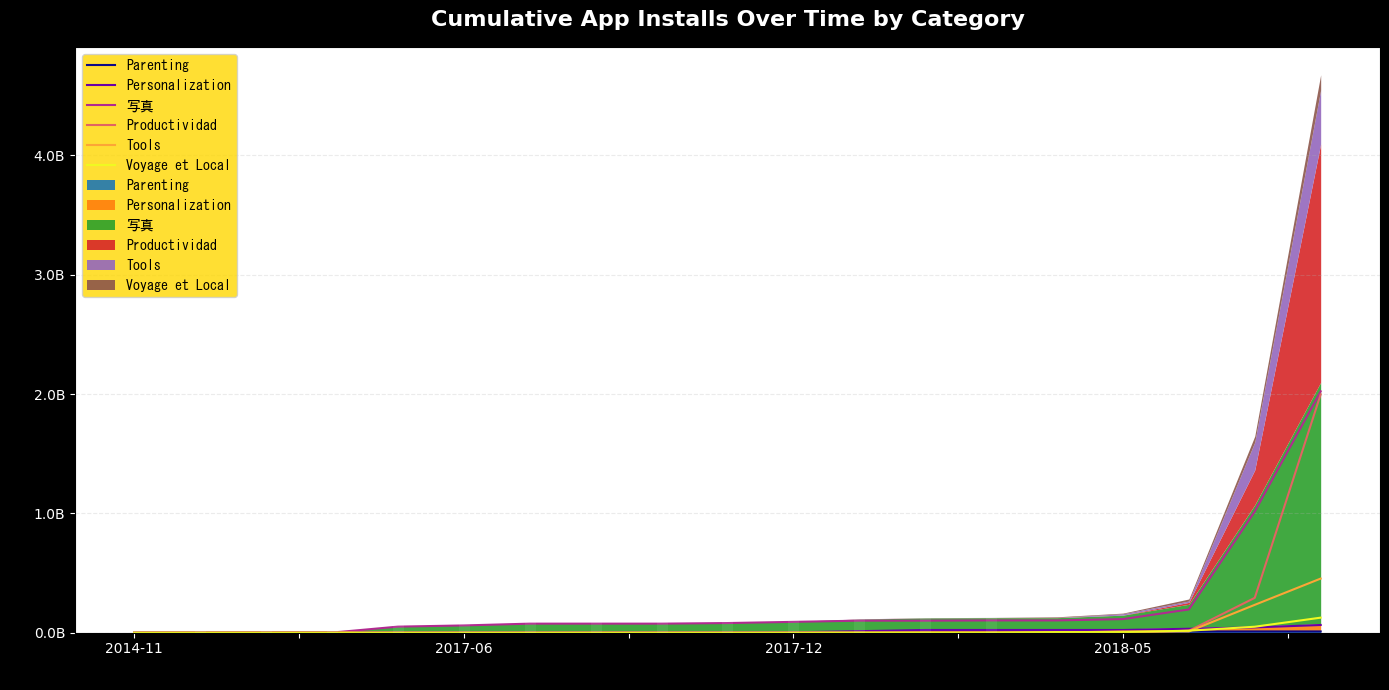

In [1]:
# import libraries

import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import pytz
import matplotlib.ticker as mtick
import matplotlib as mpl
from matplotlib.font_manager import FontProperties
#time setting
IST = pytz.timezone("Asia/Kolkata")
current_time = datetime.now(IST)

if not (6 <= current_time.hour < 22):
    print("Visualization is only available between 1 AM and 12 PM IST")
    raise SystemExit
# font setting
jp_font = FontProperties(fname=r"C:\\Windows\\Fonts\\msgothic.ttc", size=10)

#load data 
FILE_PATH = "Play Store Data.csv"
df = pd.read_csv(FILE_PATH)

# data cleaning
df['Installs'] = df['Installs'].str.replace('[+,]', '', regex=True)
df = df[df['Installs'] != 'Free']
df['Installs'] = df['Installs'].astype(int)
df['Reviews'] = df['Reviews'].astype(int)
df['Rating'] = pd.to_numeric(df['Rating'], errors='coerce')
df['Size'] = df['Size'].replace('Varies with device', None)
df['Size'] = df['Size'].str.replace('M', '')
df['Size'] = pd.to_numeric(df['Size'], errors='coerce')
df['Last Updated'] = pd.to_datetime(df['Last Updated'], errors='coerce')
df = df[
    (df['Rating'] >= 4.2) &
    (~df['App'].str.contains(r'\\d', regex=True)) &
    (df['Category'].str.startswith(('T', 'P'))) &
    (df['Reviews'] > 1000) &
    (df['Size'].between(20, 80))
]

# show specific month only
df['Month'] = df['Last Updated'].dt.to_period('M').astype(str)

grouped = (
    df.groupby(['Month', 'Category'])['Installs']
      .sum()
      .reset_index()
)

pivot_df = (
    grouped.pivot(index='Month', columns='Category', values='Installs')
            .fillna(0)
            .cumsum()
)

#growth detection
growth = pivot_df.pct_change()
highlight_months = growth[growth > 0.25].any(axis=1)

# visualation 
fig, ax = plt.subplots(figsize=(14, 7))
fig.patch.set_facecolor("black")
ax.set_facecolor("white")

pivot_df.plot(
    colormap='plasma',
    ax=ax
)

pivot_df.plot(
    kind="area",
    stacked=True,
    ax=ax,
    alpha=0.9,
    linewidth=0
)
handles, labels = ax.get_legend_handles_labels()

translated_labels = []
for label in labels:
    if label == "TRAVEL_AND_LOCAL":
        translated_labels.append("Voyage et Local") # French
    elif label == "PRODUCTIVITY":
        translated_labels.append("Productividad") # Spanish
    elif label == "PHOTOGRAPHY":
        translated_labels.append("写真") # Japanese
    else:
        translated_labels.append(label.replace("_", " ").title())

ax.legend(
    handles,
    translated_labels,
    facecolor="gold",
    labelcolor="black",
    prop=jp_font
)

# highlighting 
for month in pivot_df.index[highlight_months]:
    ax.axvline(month, color="white", alpha=0.08, linewidth=8)
#styling
ax.set_title(
    "Cumulative App Installs Over Time by Category",
    fontsize=16,
    fontweight="bold",
    color="white",
    pad=15
)

ax.set_xlabel("Month", fontsize=12, color="black")
ax.set_ylabel("Total Installs", fontsize=12, color="black")

ax.yaxis.set_major_formatter(
    mtick.FuncFormatter(lambda x, _: f"{x/1e9:.1f}B")
)

ax.tick_params(colors="white")
ax.grid(axis="y", linestyle="--", alpha=0.25)
ax.grid(axis="x", visible=False)

plt.tight_layout()
plt.show()

